In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from FeatureEngineering_2 import *
from joblib import dump, load
from AdvancedModel_helpers import *
from sklearn import metrics
from sklearn.calibration import CalibrationDisplay
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import VarianceThreshold,RFE
from sklearn.metrics import roc_auc_score

In [2]:
# import comet_ml at the top of your file
from comet_ml import Experiment

In [9]:
# Create an experiment with your api key
exp = Experiment(
    api_key="v5q8O8LftZtvOcoXlVM8Ku8fH",
    project_name="ift6758",
    workspace="hfereidouni",
)

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: sklearn, xgboost.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/hfereidouni/ift6758/7ed50c650eed45188f3c751320e6aa22



In [61]:
if not os.path.exists("csv"):
    os.makedirs("csv")
for year in [2016,2017, 2018, 2019]: # 2020 has been excluded to be reserved as the test set
    read_a_season("../nhl_data/",year).to_csv('csv/tidy_{season}.csv'.format(season = year), sep = ',', index = False)

  2%|▏         | 140/6433 [00:03<02:27, 42.59it/s]


KeyboardInterrupt: 

In [27]:
directory = 'csv'

# Get a list of csv file names within the directory
csv_files = [f for f in os.listdir(directory) if f.endswith('.csv')]

# Sort the list of csv files
csv_files.sort()

# List to hold your DataFrames
dataframes_list = []

# Loop over the sorted list of csv files with tqdm for progress indication
for filename in tqdm(csv_files, desc="Loading files", unit="file"):
    file_path = os.path.join(directory, filename)
    df = pd.read_csv(file_path)

    # Filter the DataFrame to only include rows where 5th and 6th digits of 'game_id' are '02' (Regular Season)
    df = df[df['game_id'].astype(str).str[4:6] == '02']

    dataframes_list.append(df)

# Concatenate all the DataFrames in the list into a single DataFrame
train_val_df = pd.concat(dataframes_list, ignore_index=True)

# Sort the DataFrame first by 'game_id' and then by 'event_idx'
train_val_df = train_val_df.sort_values(by=['game_id', 'event_idx'])

# Reset the index of the sorted DataFrame
train_val_df = train_val_df.reset_index(drop=True)

Loading files:   0%|          | 0/4 [00:00<?, ?file/s]

Loading files: 100%|██████████| 4/4 [00:01<00:00,  3.15file/s]


### Load datas and One-Hot encoding

In [28]:
train_val_df=train_val_df[['game_time','period','x','y','shot_type','last_event_type',
       'x_coord_last_event', 'y_coord_last_event', 'Time_from_the_last_event',
       'Distance_from_the_last_event', 'Rebound', 'change_shot_angle', 'Speed',
       'shot_dist','angle_net', 'is_goal']]

In [29]:
train_val_shot_type_oh = onehot_generator(train_val_df[['shot_type']])
train_val_last_event_type_oh = onehot_generator(train_val_df[['last_event_type']])
train_val_df= train_val_df.drop(columns=['shot_type','last_event_type'])
train_val_df = pd.concat([train_val_df,
                       train_val_shot_type_oh.set_index(train_val_df.index),
                       train_val_last_event_type_oh.set_index(train_val_df.index)],axis=1)

In [30]:
train_val_df

,game_time,period,x,y,x_coord_last_event,y_coord_last_event,Time_from_the_last_event,Distance_from_the_last_event,Rebound,change_shot_angle,...,last_event_type_Missed Shot,last_event_type_Official Challenge,last_event_type_Penalty,last_event_type_Period End,last_event_type_Period Ready,last_event_type_Period Start,last_event_type_Shootout Complete,last_event_type_Shot,last_event_type_Stoppage,last_event_type_Takeaway
0,71,1,-77.0,5.0,-61.0,11.0,1,17.088007,False,NaN,...,0,0,0,0,0,0,0,0,0,0
1,173,1,86.0,13.0,54.0,-5.0,5,36.715120,False,NaN,...,0,0,0,0,0,0,0,0,0,0
2,241,1,23.0,-38.0,-72.0,0.0,18,102.318131,False,NaN,...,1,0,0,0,0,0,0,0,0,0
3,286,1,33.0,-15.0,77.0,-2.0,19,45.880279,False,NaN,...,1,0,0,0,0,0,0,0,0,0
4,406,1,-34.0,28.0,47.0,34.0,16,81.221918,False,NaN,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305809,1045,3,77.0,-23.0,-72.0,-21.0,21,149.013422,False,NaN,...,0,0,0,0,0,0,0,0,0,0
305810,1080,3,-76.0,38.0,-95.0,-17.0,16,58.189346,False,NaN,...,0,0,0,0,0,0,0,0,0,0
305811,1082,3,-79.0,10.0,-76.0,38.0,2,28.160256,True,26.113913,...,0,0,0,0,0,0,0,1,0,0
305812,1170,3,81.0,-7.0,-60.0,40.0,32,148.627050,False,NaN,...,1,0,0,0,0,0,0,0,0,0


### Data Pre-processing I: Drop `change_shot_angle` column where the majority of datas are NaN, then drop NaN values

In [31]:
train_val_df = train_val_df.drop(columns=['change_shot_angle'])
train_val_df = train_val_df.dropna()
len(train_val_df )

288551

In [32]:
train_X,train_Y,val_X,val_Y = split_data(train_val_df,['game_time', 'period', 'x', 'y', 'x_coord_last_event',
       'y_coord_last_event', 'Time_from_the_last_event',
       'Distance_from_the_last_event', 'Rebound', 'Speed',
       'shot_dist','angle_net', 'shot_type_Backhand', 'shot_type_Deflected',
       'shot_type_Slap Shot', 'shot_type_Snap Shot', 'shot_type_Tip-In',
       'shot_type_Wrap-around', 'shot_type_Wrist Shot', 'shot_type_nan',
       'last_event_type_Blocked Shot', 'last_event_type_Faceoff',
       'last_event_type_Game Official', 'last_event_type_Giveaway',
       'last_event_type_Goal', 'last_event_type_Hit',
       'last_event_type_Missed Shot', 'last_event_type_Official Challenge',
       'last_event_type_Penalty', 'last_event_type_Period End',
       'last_event_type_Period Ready', 'last_event_type_Period Start',
       'last_event_type_Shootout Complete', 'last_event_type_Shot',
       'last_event_type_Stoppage', 'last_event_type_Takeaway'],0.20,False)

### Data Pre-processing II: Using Variance filter method to filter low variance features

In [33]:
selector = VarianceThreshold(0.8 *(1-0.8))
X_train_pre = selector.fit_transform(train_X)
train_X_1 = train_X.loc[:,selector.get_support()]
val_X_1 = val_X.loc[:,selector.get_support()]

### Initial Model

In [34]:
from sklearn import tree

In [35]:
clf = tree.DecisionTreeClassifier()

### Hyperparameters to tune for Decision Tree
- class_weight: Important when datas are inbalance which is our case.
- criterion
- max_depth
- min_samples_split
- min_samples_leaf

In [36]:
params = {
    'class_weight':[{0:1,1:1},{0:3,1:1},{0:6,1:1},{0:12,1:1},{0:50,1:1},{0:100,1:1},{0:1000,1:1}],
    'criterion':['gini','entropy'],
    'max_depth':[1,5,10,15,20,40],
    'min_samples_split':[2,8,16,32,64],
    'min_samples_leaf':[1,2,4,16,32,64],
}

### We use Randomized Search here regarding the large amount of possible hyperparamters combination

In [37]:
dt_rs = RandomizedSearchCV(clf,params,cv=3,n_jobs=-1,scoring='roc_auc',n_iter=100)

In [38]:
dt_rs.fit(train_X_1,train_Y)

In [ ]:
print(dt_rs.best_score_)

0.7259141755956818


In [ ]:
best_params1 = dt_rs.best_params_
best_params1 

{'min_samples_split': 8,
 'min_samples_leaf': 2,
 'max_depth': 10,
 'criterion': 'gini',
 'class_weight': {0: 12, 1: 1}}

In [ ]:
dt_2 = tree.DecisionTreeClassifier(**best_params1)

### Feature Selection: After applying wrapper method and optimizing algorithm, we apply a Wrapper method(RFE) to then reduce the half of the features.

In [ ]:
rfe_selector = RFE(dt_2, n_features_to_select=6)

In [ ]:
res = rfe_selector.fit_transform(train_X_1,train_Y)

In [ ]:
train_X_rfe = train_X_1.iloc[:,rfe_selector.get_support()]
val_X_rfe= val_X_1.iloc[:,rfe_selector.get_support()]
val_X_rfe

,game_time,y,Time_from_the_last_event,Distance_from_the_last_event,Speed,shot_dist
203692,1097,-5.0,5,37.363083,7.472617,28.442925
192732,219,18.0,15,122.000000,8.133333,68.410526
242616,110,0.0,7,5.385165,0.769309,20.000000
160939,739,-36.0,37,135.665029,3.666622,43.829214
252090,78,-14.0,38,65.513357,1.724036,28.653098
...,...,...,...,...,...,...
149180,1200,3.0,11,27.294688,2.481335,12.369317
96703,187,0.0,1,31.144823,31.144823,13.000000
144851,763,-10.0,7,62.625873,8.946553,79.630396
91157,324,27.0,14,14.866069,1.061862,43.416587


### Use the optimized model and selected Features to re-train a new Model

In [ ]:
dt_3 = tree.DecisionTreeClassifier(**best_params1)

In [ ]:
dt_3.fit(train_X_rfe,train_Y)

DecisionTreeClassifier(class_weight={0: 12, 1: 1}, max_depth=10,
                       min_samples_leaf=2, min_samples_split=8)

In [ ]:
roc_auc_score(y_true=val_Y,y_score=dt_3.predict_proba(val_X_rfe)[:,1])

0.7257022698519688

### Comparing to Original model trained on all features

In [ ]:
dt_raw = tree.DecisionTreeClassifier()
dt_raw.fit(train_X,train_Y)

DecisionTreeClassifier()

In [ ]:
roc_auc_score(y_true=val_Y,y_score=dt_raw.predict_proba(val_X)[:,1])

0.5499642679963819

In [ ]:
val_res_3= dt_3.predict_proba(val_X_rfe)[:,1]
val_res_raw = dt_raw.predict_proba(val_X)[:,1]

{'web': 'https://www.comet.com/api/image/download?imageId=7860c0171fd249768dfdc4d12be1326c&experimentKey=7ed50c650eed45188f3c751320e6aa22',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=7860c0171fd249768dfdc4d12be1326c&experimentKey=7ed50c650eed45188f3c751320e6aa22',
 'imageId': '7860c0171fd249768dfdc4d12be1326c'}

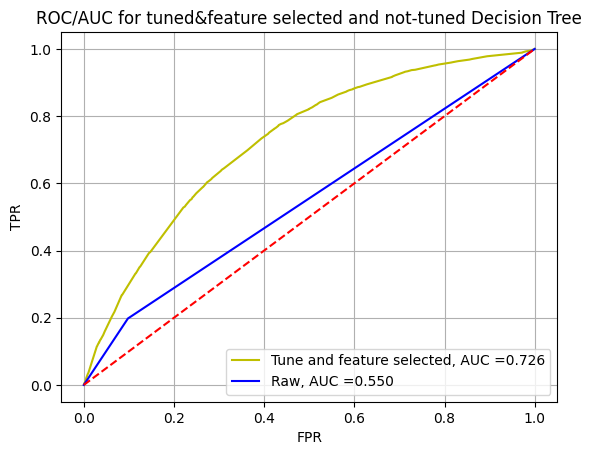

In [ ]:
fpr_3,tpr_3,threshold_3 = metrics.roc_curve(val_Y,val_res_3)
fpr_raw,tpr_raw,threshold_raw = metrics.roc_curve(val_Y,val_res_raw)

auc_3 = metrics.auc(fpr_3,tpr_3)
auc_raw = metrics.auc(fpr_raw,tpr_raw)

plt.title(f'ROC/AUC for tuned&feature selected and not-tuned Decision Tree')
plt.plot(fpr_3,tpr_3,'y',label=f"Tune and feature selected, AUC =%0.3f"%auc_3)
plt.plot(fpr_raw,tpr_raw,'b',label=f"Raw, AUC =%0.3f"%auc_raw)

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.grid(True)
plt.legend(loc="lower right")
exp.log_figure('ROC/AUC for tuned&feature selected and not-tuned Decision Tree')

In [ ]:
dt_path = './models/decision_tree_part6.joblib'
dump(dt_3,dt_path)
exp.log_model('Decision_Tree_W_FS_HT',dt_path)
exp.log_parameters(best_params1)

### Graphs

In [ ]:
precision_dt = metrics.precision_score(val_Y,dt_3.predict(val_X_rfe))
recall_dt = metrics.recall_score(val_Y,dt_3.predict(val_X_rfe))
roc_dt = roc_auc_score(y_true=val_Y,y_score=dt_3.predict_proba(val_X_rfe)[:,1])

In [ ]:
metrics = {
    'precision_dt':precision_dt,
    'recall_dt':recall_dt,
    'roc_dt':roc_dt
}

In [ ]:
exp.log_metrics(metrics)

In [ ]:
features = train_X_rfe.columns
features

Index(['game_time', 'y', 'Time_from_the_last_event',
       'Distance_from_the_last_event', 'Speed', 'shot_dist'],
      dtype='object')


### Figures

In [ ]:
train_X_dt = train_X[['game_time', 'y', 'Time_from_the_last_event',
       'Distance_from_the_last_event', 'Speed', 'shot_dist']]
val_X_dt = val_X[['game_time', 'y', 'Time_from_the_last_event',
       'Distance_from_the_last_event', 'Speed', 'shot_dist']]

In [ ]:
val_X_dt

,game_time,y,Time_from_the_last_event,Distance_from_the_last_event,Speed,shot_dist
203692,1097,-5.0,5,37.363083,7.472617,28.442925
192732,219,18.0,15,122.000000,8.133333,68.410526
242616,110,0.0,7,5.385165,0.769309,20.000000
160939,739,-36.0,37,135.665029,3.666622,43.829214
252090,78,-14.0,38,65.513357,1.724036,28.653098
...,...,...,...,...,...,...
149180,1200,3.0,11,27.294688,2.481335,12.369317
96703,187,0.0,1,31.144823,31.144823,13.000000
144851,763,-10.0,7,62.625873,8.946553,79.630396
91157,324,27.0,14,14.866069,1.061862,43.416587


In [ ]:
dt_path = './models/decision_tree_part6.joblib'
dt_f = load(dt_path)

In [ ]:
dt_f

DecisionTreeClassifier(class_weight={0: 12, 1: 1}, max_depth=10,
                       min_samples_leaf=2, min_samples_split=8)

### ROC/AUC

In [ ]:
predict_proba = dt_f.predict_proba(val_X_dt)
val_res = predict_proba[:,1]

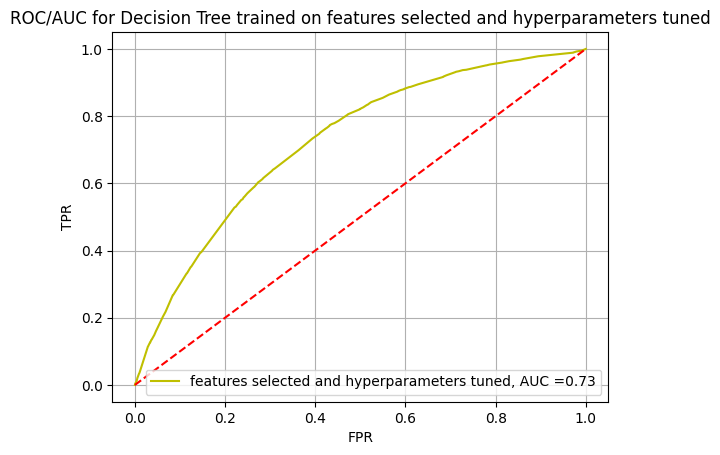

In [ ]:
fpr,tpr,threshold,roc_auc_score = roc_auc_plot(val_Y,predict_proba,'Decision Tree','features selected and hyperparameters tuned')
exp.log_figure(figure_name='ROC/AUC for Decision Tree trained with features selected and hyperparameters tuned')

In [ ]:
probas_and_label = helper_df(val_Y,predict_proba)
probas_and_label

,is_goal,goal_proba,#goal+#shot,#goal,#goal/#goal+#shot,rank,goal_prob_sum,goal_prob_cumulative_sum,cum_percent
252232,0,1.0,1,0.0,0.000000,99.961013,916794.82562,0.000000,0.000000
240732,0,1.0,2,0.0,0.000000,99.961013,916794.82562,0.000000,0.000000
164998,0,1.0,3,0.0,0.000000,99.961013,916794.82562,0.000000,0.000000
41706,0,1.0,4,0.0,0.000000,99.961013,916794.82562,0.000000,0.000000
85746,0,1.0,5,0.0,0.000000,99.961013,916794.82562,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...
157150,0,0.0,57707,5316.0,9.212054,0.382076,916794.82562,916757.979001,99.995981
92168,0,0.0,57708,5316.0,9.211894,0.382076,916794.82562,916767.190895,99.996986
80090,0,0.0,57709,5316.0,9.211735,0.382076,916794.82562,916776.402630,99.997991
41315,0,0.0,57710,5316.0,9.211575,0.382076,916794.82562,916785.614205,99.998995


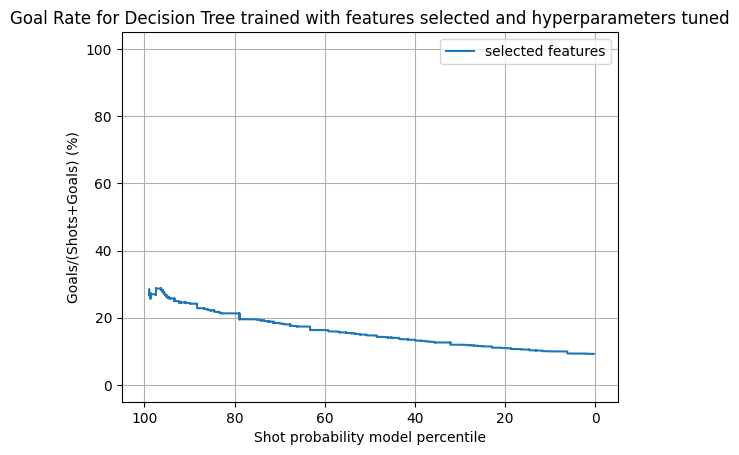

In [ ]:
start_length = int(len(probas_and_label)*0.01)
plt.plot(probas_and_label['rank'].iloc[start_length:],probas_and_label['#goal/#goal+#shot'].iloc[start_length:],label="selected features")
plt.title(f'Goal Rate for Decision Tree trained with features selected and hyperparameters tuned')
plt.xlim([105,-5])
plt.ylim([-5,105])
plt.grid(True)
plt.ylabel("Goals/(Shots+Goals) (%)")
plt.xlabel("Shot probability model percentile")
plt.legend()
exp.log_figure(figure_name='Goal Rate for Decision Tree trained with features selected and hyperparameters tuned')

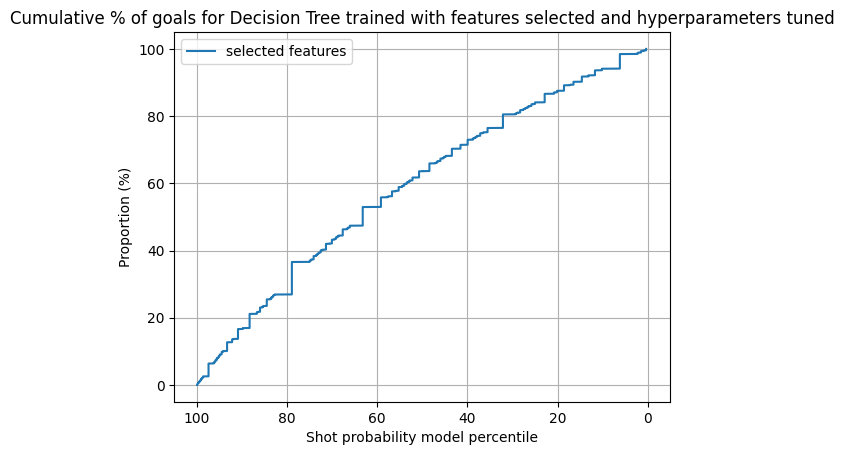

In [ ]:
plt.plot(probas_and_label['rank'],probas_and_label['cum_percent'],label="selected features")
plt.title(f'Cumulative % of goals for Decision Tree trained with features selected and hyperparameters tuned')
plt.xlim([105,-5])
plt.ylim([-5,105])
plt.grid(True)
plt.ylabel("Proportion (%)")
plt.xlabel("Shot probability model percentile")
plt.legend()
exp.log_figure(figure_name=f'Cumulative % of goals for Decision Tree trained with features selected and hyperparameters tuned')

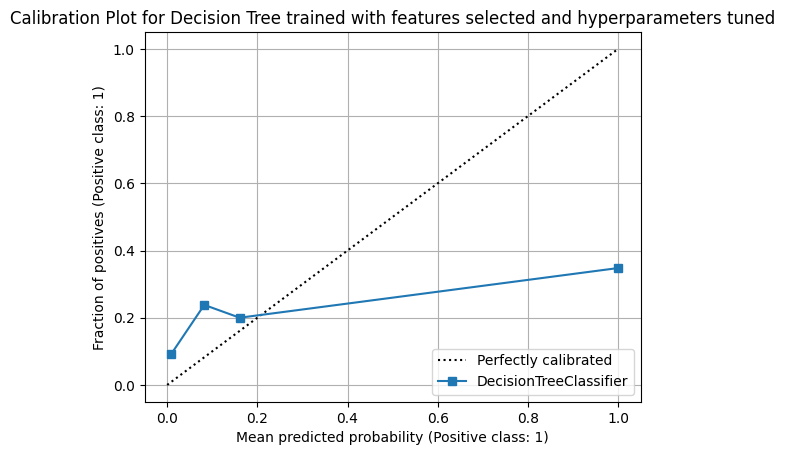

In [ ]:
disp = CalibrationDisplay.from_estimator(dt_f,val_X_dt,val_Y,n_bins=15)
plt.title("Calibration Plot for Decision Tree trained with features selected and hyperparameters tuned")
plt.grid(True)
exp.log_figure(figure_name=f'Calibration Plot for Decision Tree trained with features selected and hyperparameters tuned')

In [ ]:
exp.end()